<b>Gemini and Vertex can generate images for online sales</b>

Gemini, Google's latest and most advanced model, can help you create beautiful images with Vertex's image generation API. Use this notebook to generate images you can use for online marketing.

<b>[Required] Set up a Google Cloud account</b>

Okay so we get it, this part is hard, but in order to use the Cloud speech-to-text API you need to set up a Cloud account, project, and billing. Start [here](https://console.cloud.google.com/getting-started).

Once you've done that, come back here.

In [1]:
#@title Authenticate with Google Cloud and your project ID

import vertexai
from vertexai.preview.vision_models import Image, ImageGenerationModel

from google.colab import auth

gcp_project_id = 'advait-450518' # @param {type: "string"}

auth.authenticate_user(project_id=gcp_project_id)

vertexai.init(project=gcp_project_id)

In [2]:
#@title Configure Gemini API key

#Access your Gemini API key

import google.generativeai as genai
from google.colab import userdata

gemini_api_secret_name = 'API'  # @param {type: "string"}

try:
  GOOGLE_API_KEY=userdata.get(gemini_api_secret_name)
  genai.configure(api_key=GOOGLE_API_KEY)
except userdata.SecretNotFoundError as e:
   print(f'Secret not found\n\nThis expects you to create a secret named {gemini_api_secret_name} in Colab\n\nVisit https://makersuite.google.com/app/apikey to create an API key\n\nStore that in the secrets section on the left side of the notebook (key icon)\n\nName the secret {gemini_api_secret_name}')
   raise e
except userdata.NotebookAccessError as e:
  print(f'You need to grant this notebook access to the {gemini_api_secret_name} secret in order for the notebook to access Gemini on your behalf.')
  raise e
except Exception as e:
  # unknown error
  print(f"There was an unknown error. Ensure you have a secret {gemini_api_secret_name} stored in Colab and it's a valid key from https://makersuite.google.com/app/apikey")
  raise e

model = genai.GenerativeModel('gemini-pro')

In [3]:
! git clone https://github.com/deepseek-ai/janus

Cloning into 'janus'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 121 (delta 51), reused 36 (delta 36), pack-reused 47 (from 2)
Receiving objects: 100% (121/121), 7.19 MiB | 40.01 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [4]:
%cd janus

/content/janus


In [5]:
! pip install -e


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-e option requires 1 argument


In [7]:
!pip install attrdict

import os
import torch
import PIL.Image
import numpy as np
from transformers import AutoModel
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

In [9]:
model_path="deepseek-ai/Janus-Pro-1B"
vl_chat_processor=VLChatProcessor.from_pretrained(model_path)
tokenizer=vl_chat_processor.tokenizer
vl_gpt=AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True)
vl_gpt=vl_gpt.to(torch.bfloat16).cuda().eval

Some kwargs in processor config are unused and will not have any effect: add_special_token, sft_format, mask_prompt, num_image_tokens, ignore_id, image_tag. 


In [18]:
# Ensure the 'generated_samples' folder exists
if not os.path.exists('generated_samples'):
    os.makedirs('generated_samples')


In [24]:
@torch.inference_mode()
def generate_logo():
    parallel_size = 1  # Number of generated images
    cfg_weight = 1.5
    image_token_num_per_image = 576
    patch_size = 16
    img_size = 384  # Size of the generated image

    # Encode the input prompt
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor([input_ids]).cuda()

    tokens = torch.zeros(parallel_size, len(input_ids[0]), dtype=torch.int).cuda()
    for i in range(parallel_size):
        tokens[i, :len(input_ids[0])] = input_ids[0]

    input_embeds = vl_gpt.language_model.get_input_embeddings()(tokens)

    # Generate the image tokens
    generated_tokens = torch.zeros(parallel_size, image_token_num_per_image, dtype=torch.int).cuda()

    for i in range(image_token_num_per_image):
        outputs = vl_gpt.language_model(
            inputs_embeds=input_embeds,
            use_cache=True,
            past_key_values=(outputs.past_key_values if i > 0 else None)
        )

        logits = outputs.logits[:, -1, :]
        logit_cond = logits[:, 1]
        logit_uncond = logits[:, 2]

        logits = logit_uncond + cfg_weight * (logit_cond - logit_uncond)
        probs = torch.softmax(logits / 1.0, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)

        # Debugging the shape of the next_token tensor
        print("Shape of next_token:", next_token.shape)

        # Correcting the dimension issue
        next_token = next_token.squeeze(dim=-1)  # Squeeze the last dimension
        next_token = next_token.view(-1)  # Flatten to 1D

        generated_tokens[:, i] = next_token

    # Decode the generated tokens into images
    dec = vl_gpt.image_decoder.decode_code(
        generated_tokens.to(dtype=torch.int),
        shape=[parallel_size, img_size // patch_size, img_size // patch_size]
    )

    dec = dec.permute(0, 2, 3, 1).contiguous().cpu().numpy()
    dec = ((dec + 1) / 2 * 255).astype("uint8")

    visual_img = torch.tensor(dec).reshape(parallel_size, img_size, img_size, 3)

    # Save the generated logo
    for i in range(parallel_size):  # Ensure this block is inside the function
        save_path = f"generated_chase_logo_{i}.jpg"
        img = Image.fromarray(dec[i])
        img.save(save_path)
        print(f"Saving logo to: {save_path}")  # Debugging: confirm where the image is saved


FileNotFoundError: [Errno 2] No such file or directory: 'generated_chase_logo_0.jpg'

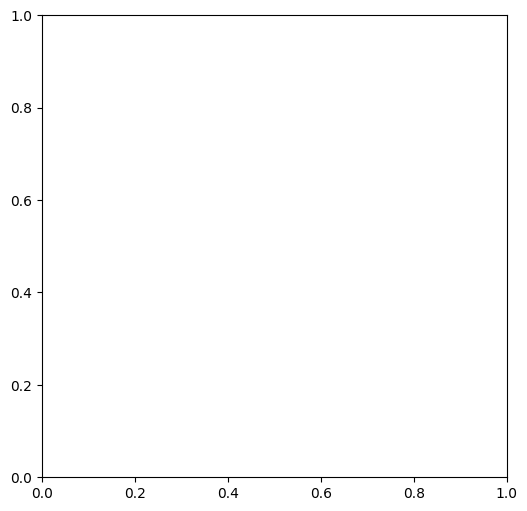

In [23]:
import os
import matplotlib.pyplot as plt

folder_path = '.'  # Make sure this folder contains your generated logos
fig, axes = plt.subplots(1, 1, figsize=(6, 6))  # Single logo display
axes.imshow(plt.imread('generated_chase_logo_0.jpg'))  # Adjust filename based on your saved logo
axes.axis('off')
axes.set_title('Generated Chase Logo')

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'generated_samples/generated_chase_logo_0.jpg'

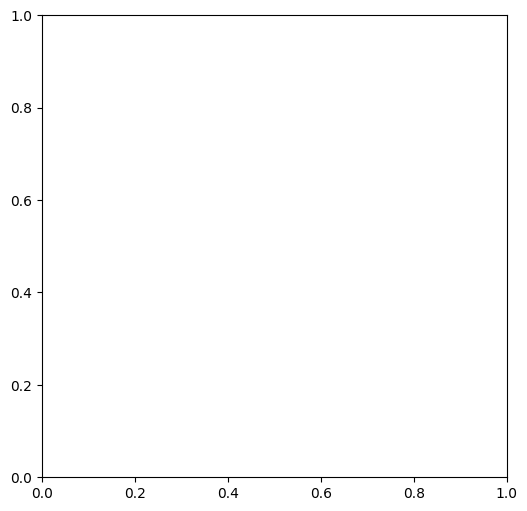

In [25]:
import os
import matplotlib.pyplot as plt

folder_path = 'generated_samples'  # Path to the folder where images are saved
fig, axes = plt.subplots(1, 1, figsize=(6, 6))  # Single logo display

# Adjust filename based on the folder path
img_path = os.path.join(folder_path, 'generated_chase_logo_0.jpg')  # Load the first logo from the folder
axes.imshow(plt.imread(img_path))  # Load and display the image
axes.axis('off')
axes.set_title('Generated Chase Logo')

plt.show()


In [ ]:
import os
import torch
from PIL import Image
from transformers import AutoModelForCausalLM
from janus.models import VLChatProcessor
import matplotlib.pyplot as plt

# Setup model and tokenizer
model_path = "deepseek-ai/Janus-Pro-1B"
vl_chat_processor = VLChatProcessor.from_pretrained(model_path)
vl_gpt = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

# Ensure the 'generated_samples' folder exists
folder_path = 'generated_samples'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Define a conversation prompt for the Chase logo
conversation = [
    {
        "role": "<|User|>",
        "content": "Generate a logo for Chase. The background is blue, and the word 'Chase' is displayed prominently in white, using a clean and professional font. The text should be centered horizontally. Include the iconic geometric symbol used by Chase, such as the blue hexagon, next to the text. The design should reflect the modern and corporate feel of Chase's branding."
    },
    {
        "role": "<|Assistant|>",
        "content": ""
    }
]

# Prepare the input for the model
sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt=""
)

# Construct the full prompt
prompt = sft_format + vl_chat_processor.image_start_tag

@torch.inference_mode()
def generate_logo():
    parallel_size = 1  # Number of generated images
    cfg_weight = 1.5
    image_token_num_per_image = 576
    patch_size = 16
    img_size = 384  # Size of the generated image

    # Encode the input prompt
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor([input_ids]).cuda()

    tokens = torch.zeros(parallel_size, len(input_ids[0]), dtype=torch.int).cuda()
    for i in range(parallel_size):
        tokens[i, :len(input_ids[0])] = input_ids[0]

    input_embeds = vl_gpt.language_model.get_input_embeddings()(tokens)

    # Generate the image tokens
    generated_tokens = torch.zeros(parallel_size, image_token_num_per_image, dtype=torch.int).cuda()

    for i in range(image_token_num_per_image):
        outputs = vl_gpt.language_model(
            inputs_embeds=input_embeds,
            use_cache=True,
            past_key_values=(outputs.past_key_values if i > 0 else None)
        )

        logits = outputs.logits[:, -1, :]
        logit_cond = logits[:, 1]
        logit_uncond = logits[:, 2]

        logits = logit_uncond + cfg_weight * (logit_cond - logit_uncond)
        probs = torch.softmax(logits / 1.0, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)

        # Debugging the shape of the next_token tensor
        print("Shape of next_token:", next_token.shape)

        # Correcting the dimension issue
        next_token = next_token.squeeze(dim=-1)  # Squeeze the last dimension
        next_token = next_token.view(-1)  # Flatten to 1D

        generated_tokens[:, i] = next_token

    # Decode the generated tokens into images
    dec = vl_gpt.image_decoder.decode_code(
        generated_tokens.to(dtype=torch.int),
        shape=[parallel_size, img_size // patch_size, img_size // patch_size]
    )

    dec = dec.permute(0, 2, 3, 1).contiguous().cpu().numpy()
    dec = ((dec + 1) / 2 * 255).astype("uint8")

    visual_img = torch.tensor(dec).reshape(parallel_size, img_size, img_size, 3)

    # Save the generated logo
    for i in range(parallel_size):  # Ensure this block is inside the function
        save_path = os.path.join(folder_path, f"generated_chase_logo_{i}.jpg")
        img = Image.fromarray(dec[i])
        img.save(save_path)
        print(f"Saving logo to: {save_path}")  # Debugging: confirm where the image is saved

# Generate the logo
generate_logo()

# Plotting the generated image
fig, axes = plt.subplots(1, 1, figsize=(6, 6))  # Single logo display

# Adjust filename based on the folder path
img_path = os.path.join(folder_path, 'generated_chase_logo_0.jpg')  # Load the first logo from the folder
axes.imshow(plt.imread(img_path))  # Load and display the image
axes.axis('off')
axes.set_title('Generated Chase Logo')

plt.show()


Some kwargs in processor config are unused and will not have any effect: add_special_token, sft_format, mask_prompt, num_image_tokens, ignore_id, image_tag. 


Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
Shape of next_token: torch.Size([1])
S